In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from astropy.io import fits

In [2]:
science_list = np.genfromtxt('science/science.list', dtype=str)

In [3]:
science_test_list = science_list[1100:1110]

In [4]:
science_frame_name = 'correct/' + science_test_list[0][:-5] + '_corr.p'

In [5]:
science_corrected = pickle.load(open(science_frame_name, 'rb'))

In [6]:
vmin = np.amin(science_corrected[:, 100:400])
vmax = np.amin(science_corrected[:, 100:400])
print(vmin, vmax)

556.1800013908436 556.1800013908436


In [7]:
vmax = 2000

In [8]:
%matplotlib widget 

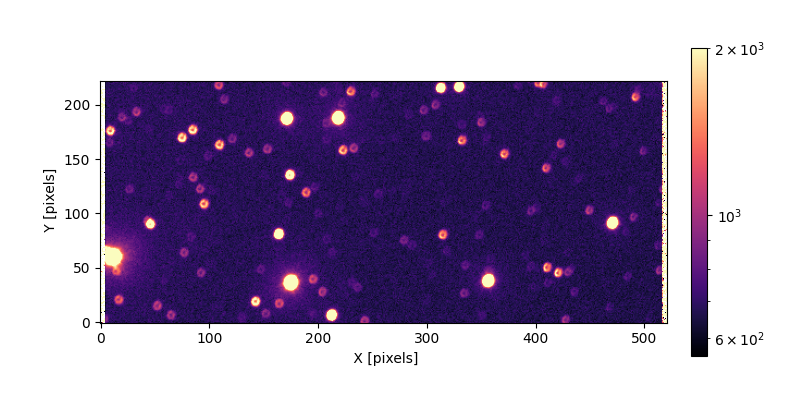

In [9]:
fig, ax = plt.subplots(1, figsize=(8,4))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], 
                 norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                 origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.show()

In [10]:
x_target = 356
y_target = 39

x_ref = 171
y_ref = 187

In [11]:
def make_circle_around_star(x_pos, y_pos, label='', color='w'):
    from matplotlib.patches import Circle
    n, radii = 50, [9,12]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    xs[1:,] = xs[1,::-1]
    ys[1:,] = ys[1,::-1]
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, 
            edgecolor=None,
            facecolor=color,
            alpha=0.75,
            label=label)

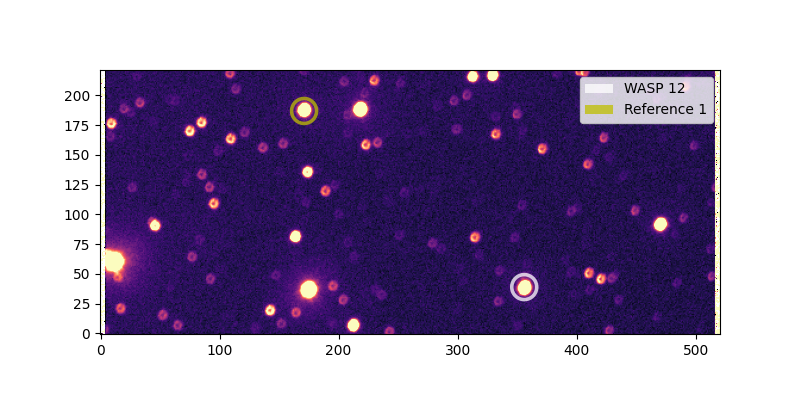

In [12]:
fig, ax = plt.subplots(1, figsize=(8,4))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], 
                 norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                 origin='lower')
make_circle_around_star(x_target, y_target, label='WASP 12')
make_circle_around_star(x_ref, y_ref, label='Reference 1', color ='y')
plt.legend()
plt.show()

In [13]:
def make_thin_circle_around_star(x_pos, y_pos, radius, thickness=0.5,label='', color='w'):
    from matplotlib.patches import Circle
    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    xs[1:,] = xs[1,::-1]
    ys[1:,] = ys[1,::-1]
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, 
            edgecolor=None,
            facecolor=color,
            alpha=0.75,
            label=label)

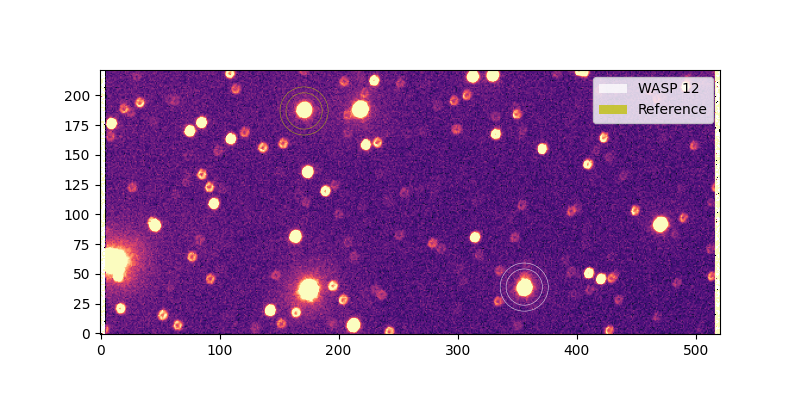

In [14]:
fig, ax = plt.subplots(1, figsize=(8,4))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], 
                 norm=colors.LogNorm(vmin=vmin, vmax=2*vmin), 
                 origin='lower')
make_thin_circle_around_star(x_target, y_target, radius=15,label='WASP 12') #inner circle
make_thin_circle_around_star(x_target, y_target, radius=20,) #outer circle
make_thin_circle_around_star(x_ref, y_ref, radius=15,label='Reference', color ='y') #inner circle
make_thin_circle_around_star(x_ref, y_ref, radius=20, color ='y') #outer circle
plt.legend()
plt.show()

The radius of the inner circle should be large enough to get all the flux of the star and allow for some movement throughout the night.

## Determining centroid of star

for i in range(...), for j in range(...). 

Implementing the numpy.meshgrid package.

In [15]:
ylen,xlen = np.shape(science_corrected)

x_axis = np.arange(0, xlen,1)
y_axis = np.arange(0, ylen,1)

#creating a grid of all the pixels within the corrected science image
X,Y=np.meshgrid(x_axis, y_axis)

#calculating their distance from the center of the target star
distance = np.sqrt( (X-x_target)**2 + (Y-y_target)**2) 

In [16]:
inner_radius = 15
selection = (distance < inner_radius)
weighted_x = np.sum(X[selection] * science_corrected[selection])
weighted_y = np.sum(Y[selection] * science_corrected[selection])
total_flux = np.sum(science_corrected[selection])

In [17]:
print(weighted_x/total_flux)
print(x_target)

355.99418875707994
356


In [18]:
x_target_corr = weighted_x/total_flux
y_target_corr = weighted_y/total_flux

In [19]:
print("Change of target X coord from", x_target, "to", x_target_corr)
print('Change of target Y coord from', y_target, 'to', y_target_corr)

Change of target X coord from 356 to 355.99418875707994
Change of target Y coord from 39 to 38.46903063457054


In [ ]:
##can repeat this several times over the night to make sure that your inner circle is still containing all of the flux from the star.

In [20]:
maxiterat = 30

x_init = x_target
y_init = y_target

for i in range(0,maxiterat):
    distance = np.sqrt( (X-x_init)**2 + (Y-y_init)**2)
    selection = (distance < inner_radius)
    
    weighted_x = np.sum(X[selection] * science_corrected[selection])
    weighted_y = np.sum(Y[selection] * science_corrected[selection])
    total_flux = np.sum(science_corrected[selection])
    
    x_target_corr = weighted_x/total_flux
    y_target_corr = weighted_y/total_flux
    
    diffx = np.abs(x_target_corr - x_init)
    diffy = np.abs(y_target_corr - y_init)
    
    x_init = x_target_corr
    y_init = y_target_corr
    
    if (diffx < 0.0001) and (diffy < 0.0001):
        break

print(i)
print(x_init, y_init)

3
355.989944270224 38.318668816499816


In [21]:
inner_radius = 15
outer_radius = 20

distance = np.sqrt( (X-x_init)**2 + (Y-y_init)**2)
sky_selection = (distance > inner_radius) & (distance < outer_radius)
sky_bkg = np.average(science_corrected[sky_selection])

In [22]:
sciencecorr_nosky = science_corrected - sky_bkg

In [ ]:
##you have to do this all over again for the reference star

In [52]:
aperture_radius = 6
aperture_selection = (distance < aperture_radius)
aperture_flux = np.sum(sciencecorr_nosky[aperture_selection])

In [67]:
#how do i select the aperture radius??

aperture_array = np.zeros((inner_radius, 2))

for aperture_radius in range(1,inner_radius):
    
    aperture_selection = (distance < aperture_radius)
    aperture_flux = np.sum(sciencecorr_nosky[aperture_selection])
    
    aperture_array[aperture_radius - 1] = (aperture_radius, aperture_flux)

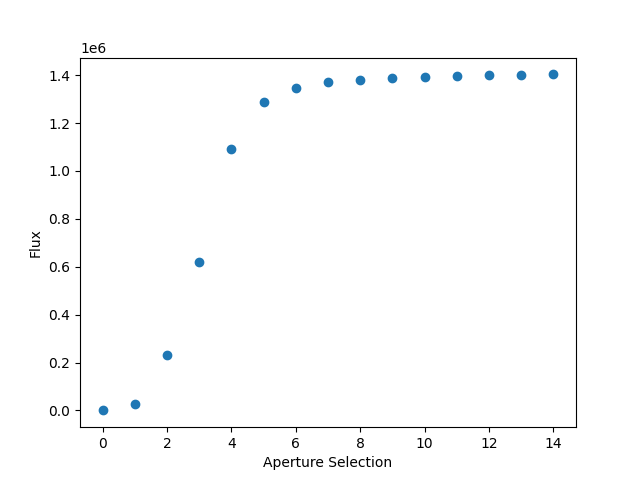

In [80]:
plt.figure()

plt.scatter(aperture_array[:,0], aperture_array[:,1])
plt.xlabel('Aperture Selection')
plt.ylabel('Flux')
plt.show()

In [75]:
aperture_array[:,0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.,  0.])